# Deep backward schemes for high-dimensional nonlinear PDEs

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("..")

Import our `dbdp` package.

In [2]:
from dbdp import DBDPModel
from dbdp.solvers import DBDP1Solver
from dbdp.utils import get_device

## Example 1 :

$$
    \mu=0.2,\ \sigma=1,\ T=2,\ x_0=1
$$

$$
    g(x)=\cos(x)
$$

$$
    f(t,x,y,z)=(\cos(x)(e^{\frac{T-t}{2}}+\sigma^2/2)+\mu\sin(x))e^{\frac{T-t}{2}}-\frac{1}{2}(\sin(x)\cos(x)e^{T-t})^2+\frac{1}{2}(yz)^2
$$

To use `dbdp` for solving PDEs, you need to create a class that extend `DBDPModel` and define dynamic of the problem :

Avoid using `np` methods since `numpy` runs only on CPU and might be slower than `torch` code.

In [3]:
class Example1Model(DBDPModel):
    def __init__(self, mu: float, sigma: float, maturity: float):
        super().__init__()
        self.mu = self.make_buffer(mu)
        self.sigma = self.make_buffer(sigma)
        self.maturity = self.make_buffer(maturity)

    def drift(self, t, x) -> torch.Tensor:
        return self.mu

    def diffusion(self, t, x) -> torch.Tensor:
        return self.sigma

    def f(self, t: torch.Tensor, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        a = torch.cos(x) * (torch.exp((self.maturity - t) / 2) + self.sigma**2 / 2) + self.mu * torch.sin(x)
        b = -((torch.sin(x) * torch.cos(x) * torch.exp(self.maturity - t)) ** 2) + (y * z) ** 2
        return a * torch.exp((self.maturity - t) / 2) + b / 2

    def g(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cos(x)

    @property
    def dim(self) -> int:
        return 1

In [4]:
mu = 0.2
sigma = 1.0
maturity = 2.0
x0 = torch.Tensor([1.0])  # So that x0.dim() == 1, this is important !

example1_model = Example1Model(mu, sigma, maturity)
example1_true_u = lambda t, x: np.exp((maturity - t) / 2) * torch.cos(x)

In [5]:
device = get_device("cpu")
device

device(type='cpu')

Generate datas, using `DBDPModel`.

In [6]:
time_steps = 240
dt = maturity / time_steps
sample_count = 5_000

x_paths, dw = example1_model.generate_datas(x0, dt, time_steps, sample_count)

print(f"        | Shapes                      | Memory")
print(f"--------|-----------------------------|--------")
print(f"     dw | {dw.shape} | {dw.element_size() * dw.nelement() / 1024**2:.2f} MB")
print(f"x_paths | {x_paths.shape} | {x_paths.element_size() * x_paths.nelement() / 1024**2:.2f} MB")

        | Shapes                      | Memory
--------|-----------------------------|--------
     dw | torch.Size([5000, 240, 1]) | 4.58 MB
x_paths | torch.Size([5000, 241, 1]) | 4.60 MB


In [7]:
example1_dbdp1_solver = DBDP1Solver(example1_model, dt, time_steps)
# example1_dbdp1_solver.load("../models/example-01.pt")

In [ ]:
trains_losses, tests_losses = example1_dbdp1_solver.train(
    x_paths,
    dw,
    num_epochs=400,
    batch_size=1_000,
    lr=4e-3,
    device=device,
)
# example1_dbdp1_solver.save("../models/example-01.pt")

Training: 100%|██████████| 240/240 [47:51<00:00, 11.96s/it]


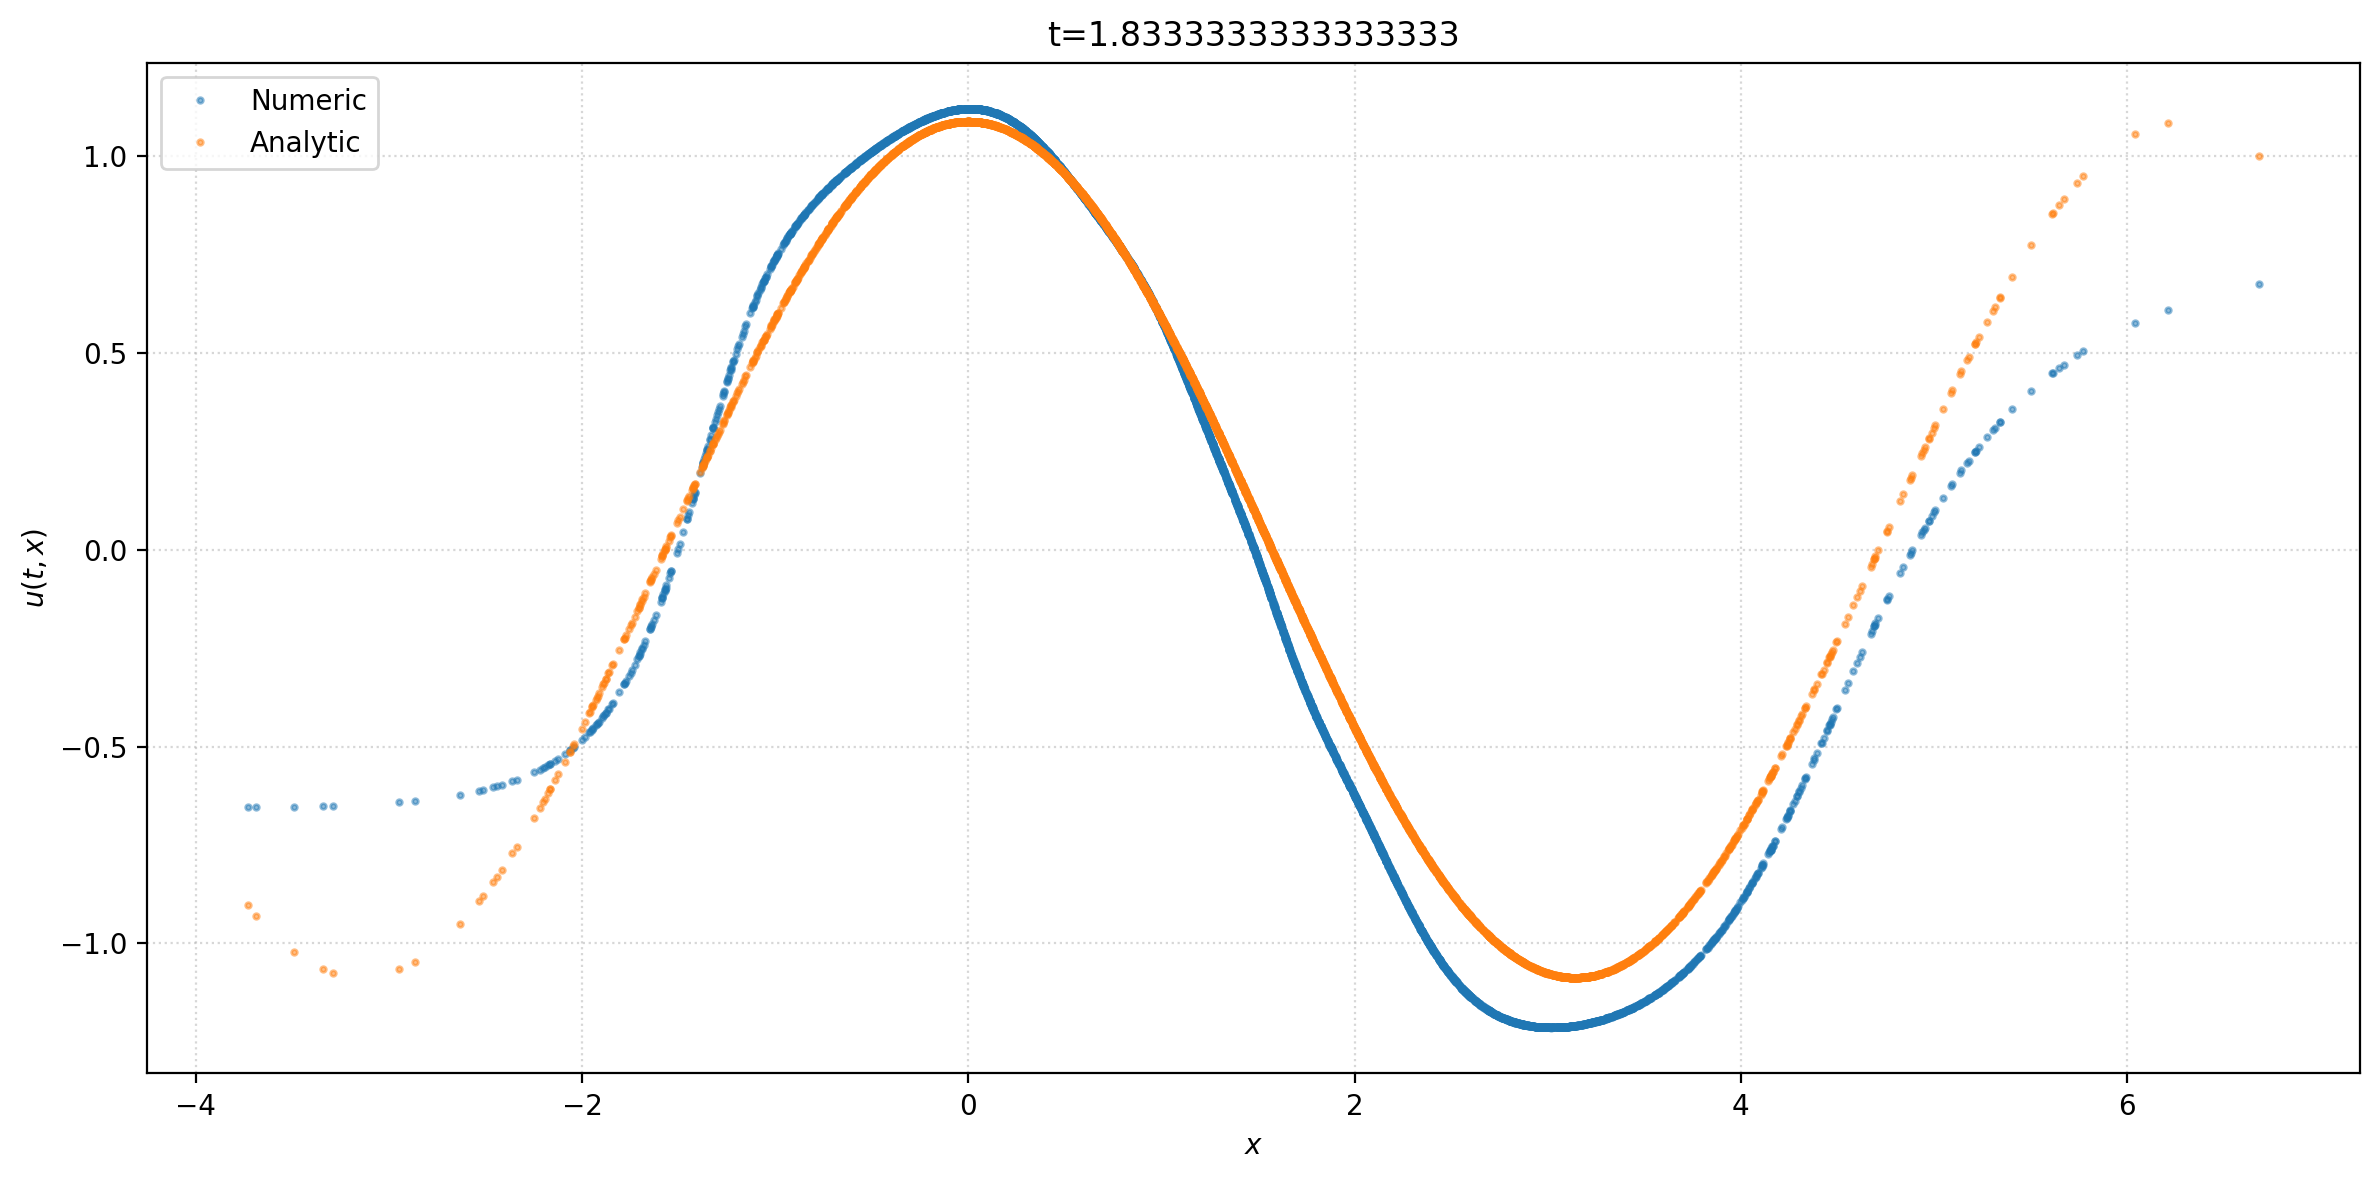

In [16]:
u_approx = example1_dbdp1_solver

time = np.linspace(0, maturity, time_steps + 1)
t = time[220]
xs = x_paths[:, 220].unsqueeze(1)[:, :, 0]
ys = u_approx(t, xs).detach()

plt.figure(figsize=(12, 6), dpi=200)
plt.title(f"t={t}")
plt.plot(xs, ys, ".", markersize=4, label="Numeric", alpha=0.5)
plt.plot(xs, example1_true_u(t, xs), ".", markersize=4, label="Analytic", alpha=0.5)
plt.grid(alpha=0.5, ls="dotted")
plt.xlabel("$x$")
plt.ylabel("$u(t,x)$")
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

In [10]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(12, 6), dpi=200)
    plt.title("Evolution of training and test error")
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.loglog()
    plt.grid(alpha=0.5, ls="dotted")
    plt.tight_layout()
    plt.legend()

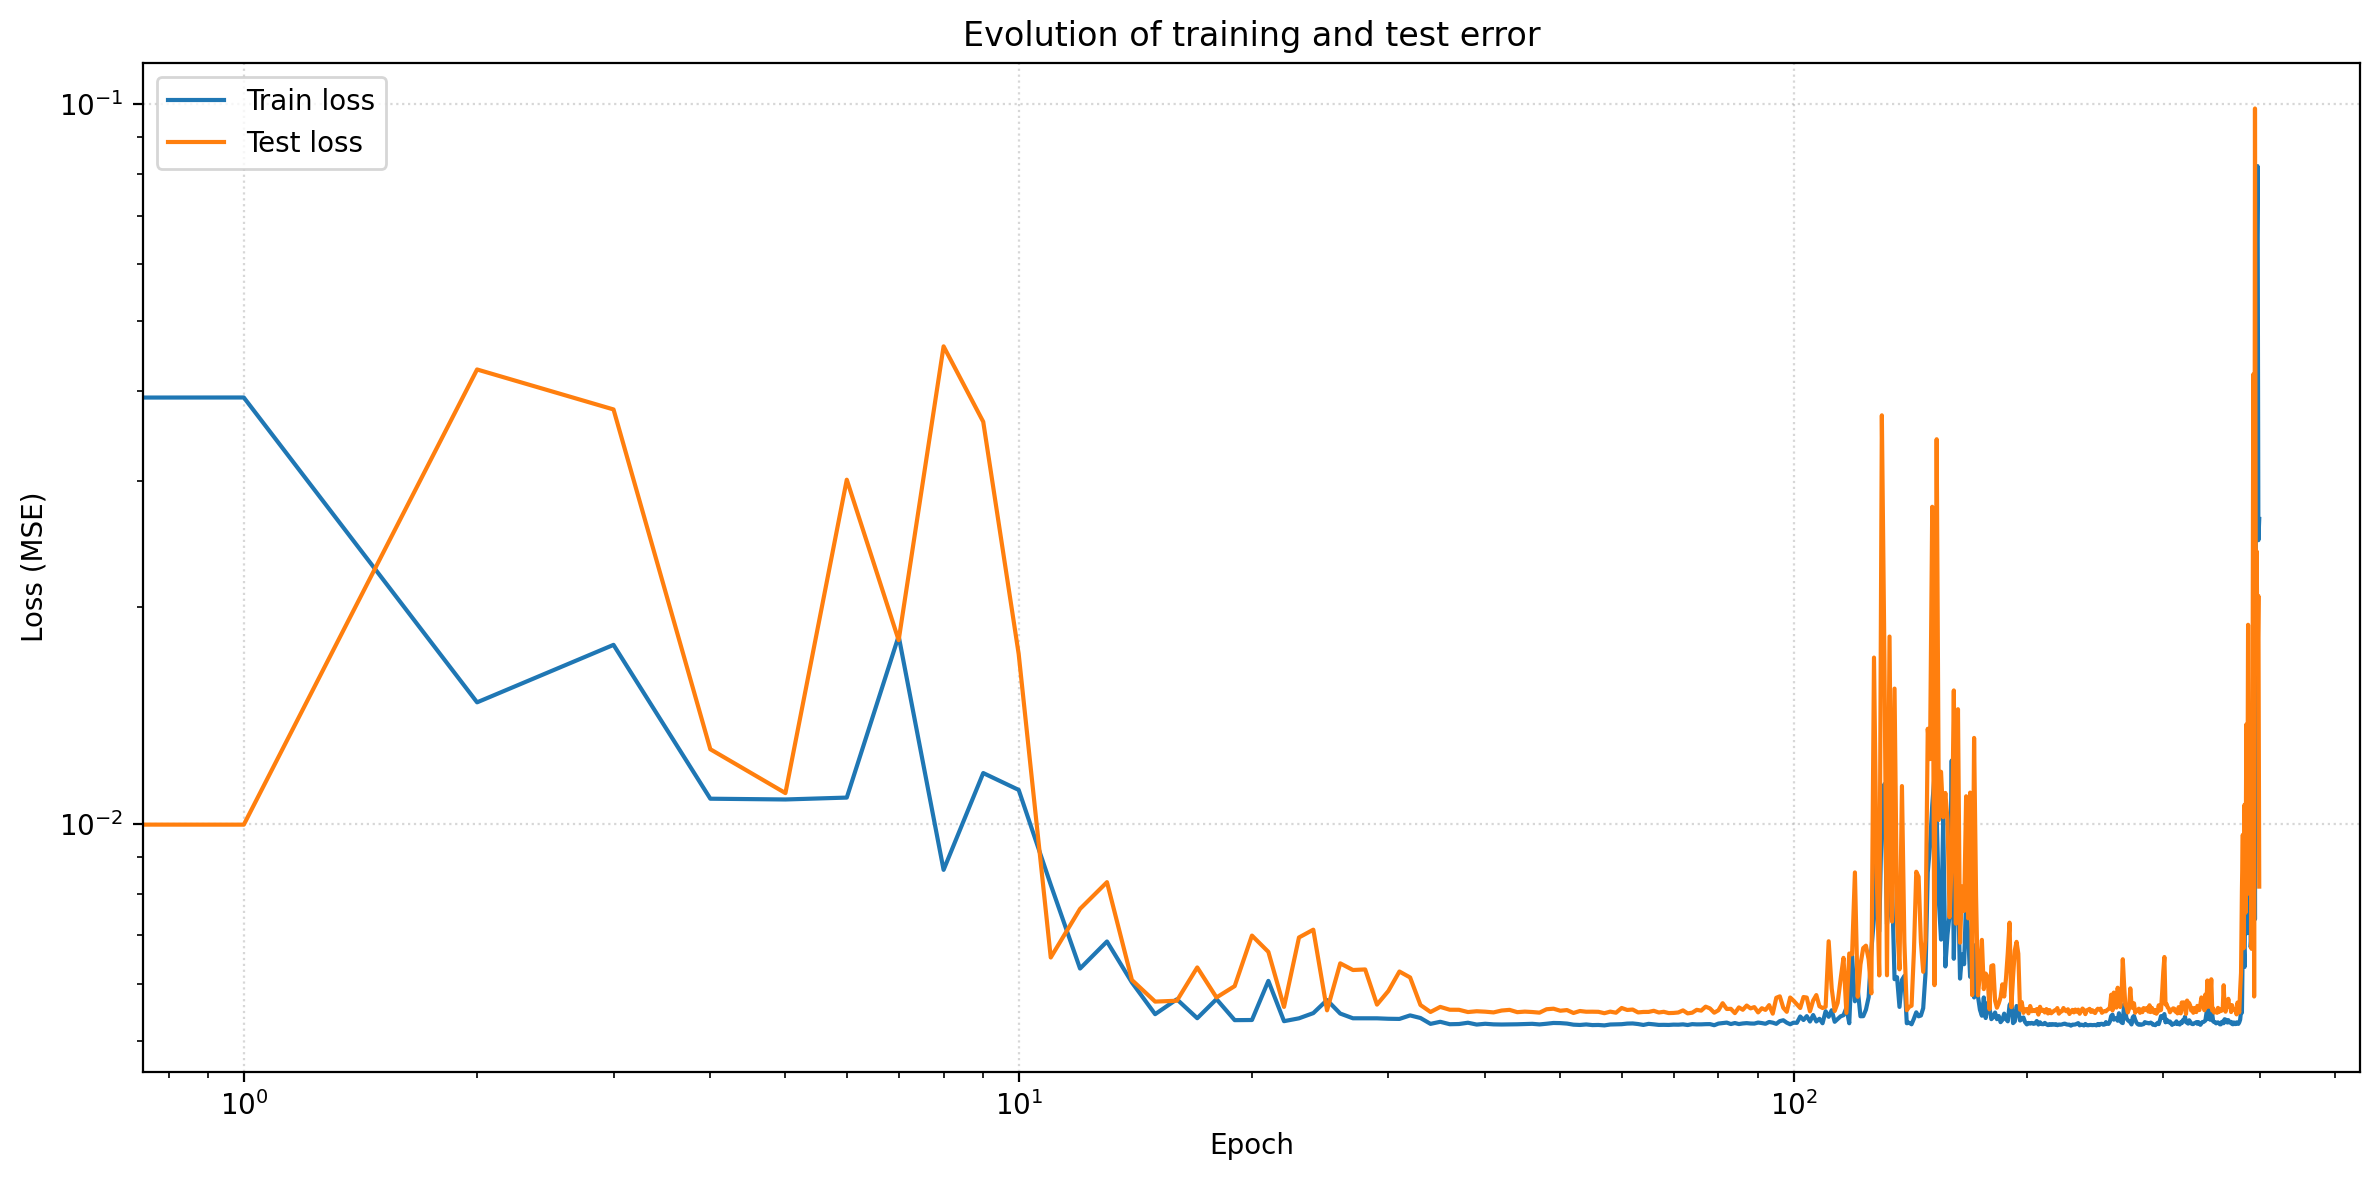

In [21]:
plot_losses(trains_losses[220], tests_losses[220])